In [99]:
import glob
import scipy
import matplotlib.pyplot as plt
import numpy as np
import json
import time
from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from datetime import datetime
import plotly.express as px
import plotly.graph_objs as go
import cupy as cp
import cupyx.scipy.signal as signal
import pandas as pd

from eve_part.data.constant import wavelength_list_eve
from eve_part.gaussian_fit_eve import gaussian_fit_eve

In [4]:
eve_files=sorted(glob.glob('eve_part/data/EVE_sav/EVS_L2*.sav'))

eve_data=[]
for eve_file in eve_files:
    eve_data.append( scipy.io.readsav(eve_file) )

In [13]:
len(eve_files)

6707

In [14]:
6707/24

279.4583333333333

## read sav files

In [ ]:
eve_files=sorted(glob.glob('data/EVE_sav/EVS_L2*.sav'))
eve_files.__len__()

In [ ]:
eve_data=[]
for eve_file in eve_files:
    eve_data.append( scipy.io.readsav(eve_file) )

In [ ]:
eve_data[0].keys()

In [ ]:
eve_data[0]['irradiance'].shape

In [ ]:
eve_data[0]['irradiance']

In [ ]:
eve_data[0]['wavelength'][1363:1375].shape

In [ ]:
eve_data[0]['wavelength'][1363:1375]

In [ ]:
len(eve_data[0]['yyyydoy'])

## resave irradiance into a dict :obs

In [5]:
obs={}
for i in range(len(eve_data)):
# for i in range(24):

    day=eve_data[i]['yyyydoy'][0]
    # if obs[day] hasn't been created, just create an empty list
    if day not in obs.keys():
        
        obs[day] =np.full((8640,12),np.nan)
    
    index=int(eve_data[i]['sod_time'][0]/10)
    
    flag=np.where(eve_data[i]['sc_flags'] == 0, 1, np.nan)*\
                np.where((eve_data[i]['flags'] == 16) | (eve_data[i]['flags'] == 1), np.nan, 1)
    
    flag=np.tile(flag.T, (12, 1)).T
     
    obs[day][index:index+360]=eve_data[i]['irradiance']*flag

In [6]:
day

2011062

In [7]:
obs.values().__len__()

47

Text(0.5, 1.0, 'invalid data')

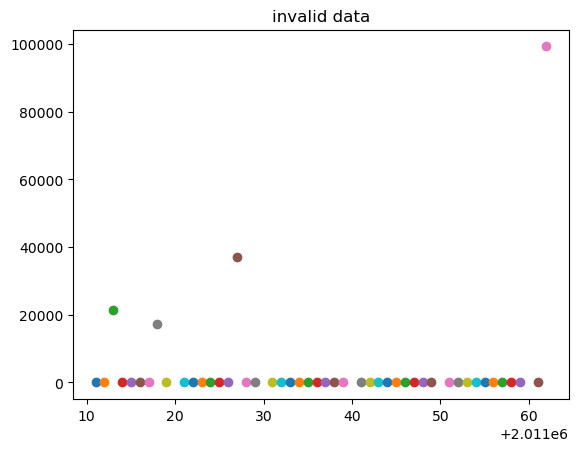

In [8]:
# invalid data num : expected 0
# total data num: 103680
fig,ax=plt.subplots()
for i in obs.keys():
    ax.scatter(i,np.sum(np.isnan(obs[i])),)
ax.set_title("invalid data")

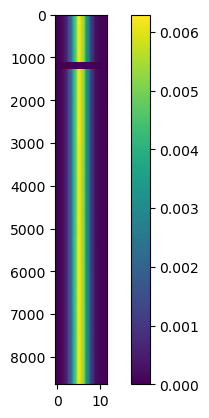

In [12]:
fig,ax=plt.subplots()
sc=ax.imshow(obs[2011011],aspect=0.01,vmin=0)
plt.colorbar(sc)

10803.319036960602

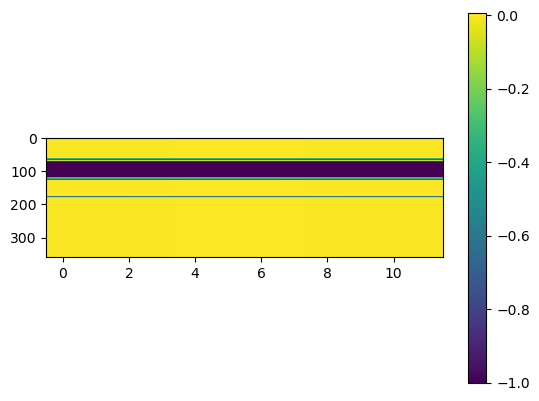

In [13]:
fig,ax=plt.subplots()
sc=ax.imshow(eve_data[3]['irradiance'],aspect=0.01)
plt.colorbar(sc)
eve_data[3]['sod_time'][0]

### before fitting
先看看每天的有效数据，还是挺多的

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


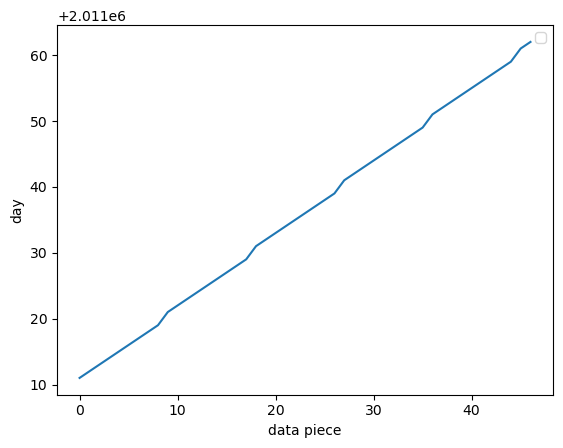

In [39]:
fig,ax=plt.subplots()
ax.plot(obs.keys())
#不是每天都有数据

ax.set_xlabel('data piece')
ax.set_ylabel('day')
ax.legend()

In [41]:
obs[2011011]

array([[2.65775398e-05, 1.30548782e-04, 5.00766444e-04, ...,
        2.02952448e-04, 7.74215005e-05, 5.15032625e-05],
       [2.40217960e-05, 1.26646890e-04, 4.99048678e-04, ...,
        2.02324998e-04, 7.55215369e-05, 4.94755514e-05],
       [2.69133889e-05, 1.31225854e-04, 5.01633505e-04, ...,
        2.08510086e-04, 8.12409417e-05, 5.37332417e-05],
       ...,
       [2.56111234e-05, 1.21492572e-04, 4.83515032e-04, ...,
        1.99302784e-04, 7.35190115e-05, 5.01047471e-05],
       [2.48915367e-05, 1.24780054e-04, 4.87379555e-04, ...,
        1.94735971e-04, 7.32705594e-05, 4.97229266e-05],
       [2.69294796e-05, 1.26975705e-04, 4.88911697e-04, ...,
        2.01900330e-04, 7.35467402e-05, 4.78482252e-05]])

In [47]:
np.sum(np.isnan(obs[2011027]))
#1月27号就是十字扫描，缺了将近1/3的数据

36936

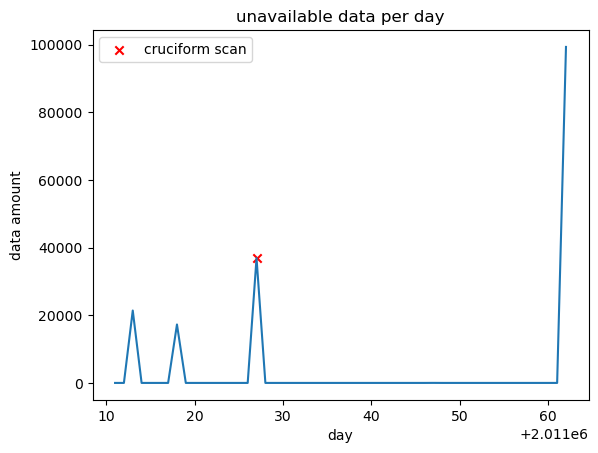

In [83]:
## 每天的有效数据量    包括了irradiance=-1的数据
fig,ax=plt.subplots()
ax.plot(obs.keys(),[np.sum(np.isnan(obs[key])) for key in obs.keys()])
ax.scatter(2011027,np.sum(np.isnan(obs[2011027])),label='cruciform scan',marker='x',c='r')
ax.set_title("unavailable data per day")

ax.set_xlabel('day')
ax.set_ylabel('data amount')
ax.legend()

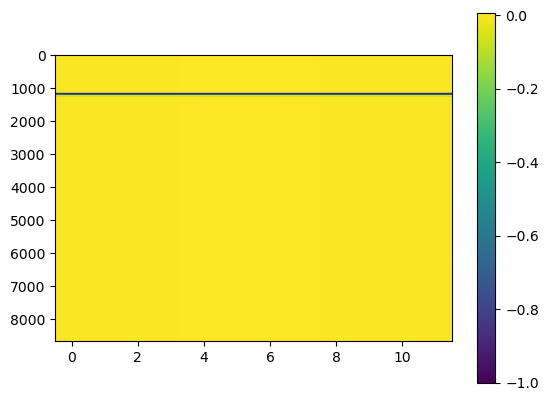

In [71]:
fig,ax=plt.subplots()
sc=ax.imshow(obs[2011011],aspect=0.001)
plt.colorbar(sc)

## fit the ave of every 10s

In [14]:
start=time.time()

obs_cen_wave={}
for key in obs.keys():
    if key not in obs_cen_wave.keys():
        obs_cen_wave[key]=np.full((8640,),np.nan)
    for j in np.arange(len(obs[key])):
        obs_cen_wave[key][j]=gaussian_fit_eve(wavelength_list_eve,obs[key][j])

end=time.time()
end-start

855.478798866272

### fitting result visualization

In [77]:
# 每天8640 个中心波长
np.shape(obs_cen_wave[2011011])

(8640,)

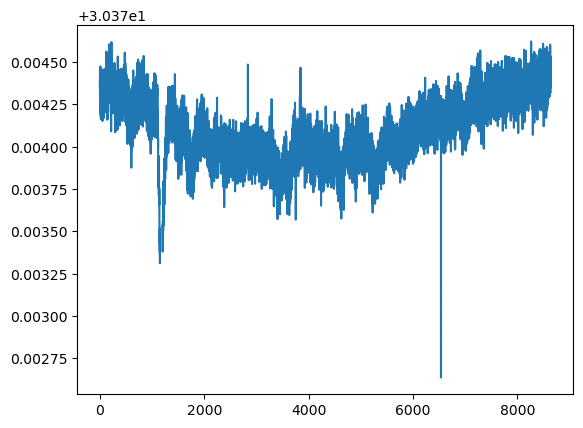

In [78]:
fig,ax=plt.subplots()
ax.plot(obs_cen_wave[2011011])

In [80]:
np.sum(np.isnan(obs_cen_wave[2011011]))

57

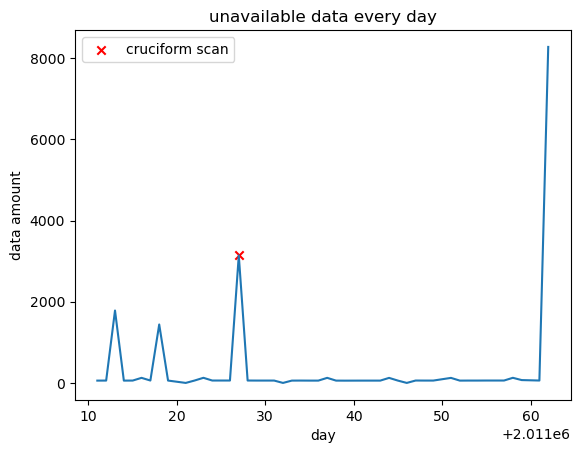

In [82]:
## 每天的有效数据量    包括了irradiance=-1的数据
# 可以看出每天都有一些无效数据
fig,ax=plt.subplots()
ax.plot(obs_cen_wave.keys(),
        [np.sum(np.isnan(obs_cen_wave[key])) for key in obs.keys()])
ax.scatter(2011027,np.sum(np.isnan(obs_cen_wave[2011027])),
           label='cruciform scan',marker='x',c='r')
ax.set_title("unavailable data every day")

ax.set_xlabel('day')
ax.set_ylabel('data amount')
ax.legend()

### fitting test

In [16]:
g_init = models.Gaussian1D(amplitude=0.005, mean=30.3, stddev=0.0424)

# initial value for fitting
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, wavelength_list_eve, obs[2011011][0])
mean = g.mean.value

In [17]:
g

<Gaussian1D(amplitude=0.00629033, mean=30.3743811, stddev=0.02865681)>

In [18]:
fit_g.fit_info

{'nfev': 12,
 'fvec': array([-1.83042451e-05, -4.81465929e-05,  3.50090260e-06,  4.80444204e-06,
         1.42053785e-06, -2.94587662e-06, -1.13911161e-06,  3.64202110e-06,
         4.32683435e-06, -9.46757495e-06, -5.33743387e-05, -4.96669674e-05]),
 'fjac': array([[-1.59362690e+00,  8.22022401e-03,  5.03041302e-02,
          1.89141155e-01,  4.36949077e-01,  6.20208933e-01,
          5.40888325e-01,  2.89827505e-01,  9.54188081e-02,
          1.93014874e-02,  2.39888796e-03,  1.83185694e-04],
        [ 1.07779407e-09,  2.47352600e-01,  1.59612783e-01,
          4.13454422e-01,  5.23883629e-01,  1.31458998e-01,
         -4.19209902e-01, -5.10687230e-01, -2.62309872e-01,
         -7.21110568e-02, -1.13300321e-02, -1.04599654e-03],
        [-1.74904690e-01,  2.31929874e-07, -2.47352447e-01,
          4.67083314e-01,  8.37699918e-02, -4.39346052e-01,
         -1.24838621e-01,  4.70812804e-01,  4.63487407e-01,
          1.82746942e-01,  3.70779976e-02,  4.18072096e-03]]),
 'ipvt': array([

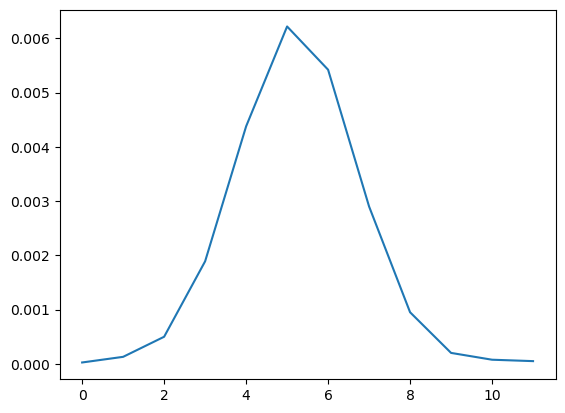

In [20]:
fig,ax=plt.subplots()
ax.plot(obs[2011011][0])

In [25]:
a=np.full((12,),1000)
a

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000])

In [26]:
g_init = models.Gaussian1D(amplitude=0.005, mean=30.3, stddev=0.0424)

# initial value for fitting
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, wavelength_list_eve, a)
mean = g.mean.value

In [28]:
g

<Gaussian1D(amplitude=1000., mean=30.31908505, stddev=16582383.65384413)>

In [27]:
fit_g.fit_info

{'nfev': 29,
 'fvec': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'fjac': array([[-3.46410162e+00,  2.88675135e-01,  2.88675135e-01,
          2.88675135e-01,  2.88675135e-01,  2.88675135e-01,
          2.88675135e-01,  2.88675135e-01,  2.88675135e-01,
          2.88675135e-01,  2.88675135e-01,  2.88675135e-01],
        [-7.67397884e-13,  8.69769345e-13,  1.89655439e-01,
          1.06031238e-01,  2.24070371e-02, -6.12171639e-02,
         -1.44841365e-01, -2.28465566e-01, -3.12089767e-01,
         -3.95713968e-01, -4.79338169e-01, -5.62962370e-01],
        [-6.44031614e-21,  6.39014960e-21,  3.20483387e-21,
          2.77158612e-01,  3.79050338e-01,  4.26197174e-01,
          4.18599120e-01,  3.56256176e-01,  2.39168342e-01,
          6.73356176e-02, -1.59241997e-01, -4.40564502e-01]]),
 'ipvt': array([1, 2, 3], dtype=int32),
 'qtf': array([ 7.08880965e-12,  6.43510575e-28, -7.02127600e-28]),
 'message': 'The relative error between two consecutive iterates is at most 0.00

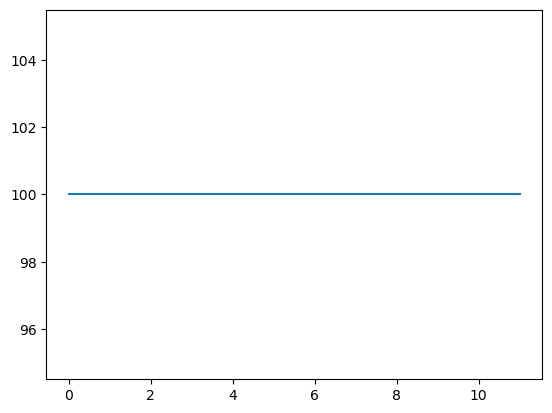

In [105]:
fig,ax=plt.subplots()
ax.plot(a)
# ax.plot(g(a))

In [106]:
g(a)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100.])

In [114]:
g

<Gaussian1D(amplitude=0.0061438, mean=30.37416666, stddev=0.02864947)>

In [93]:
a

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [18]:
start=time.time()

obs_cen_wave={}
for key in obs.keys():
    if key not in obs_cen_wave.keys():
        obs_cen_wave[key]=np.full((8640,),np.nan)
    for j in np.arange(len(obs[key])):
        obs_cen_wave[key][j]=gaussian_fit_eve(wavelength_list_eve,obs[key][j])

end=time.time()
end-start

unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful fitting
unsuccessful 

3465.04105758667

In [19]:
obs_cen_wave

{2011011: array([30.3743811 , 30.37433775, 30.37445438, ..., 30.37451108,
        30.37435202, 30.37442525]),
 2011012: array([30.37429674, 30.37433193, 30.37448087, ..., 30.37422266,
        30.37424663, 30.37436124]),
 2011013: array([30.37424214, 30.37434011, 30.37438492, ..., 30.37448186,
        30.37445229, 30.37438745]),
 2011014: array([30.37439068, 30.37435911, 30.37416811, ..., 30.37423074,
        30.3742138 , 30.37430982]),
 2011015: array([30.37416666, 30.37421266, 30.37425982, ..., 30.37405341,
        30.37435332, 30.37431698]),
 2011016: array([30.37431439, 30.37422119, 30.37429075, ..., 30.37431739,
        30.37437411, 30.37416036]),
 2011017: array([30.37426721, 30.37418408, 30.37422403, ..., 30.37429125,
        30.37430479, 30.3743965 ]),
 2011018: array([30.37422407, 30.37422297, 30.37437429, ..., 30.37444435,
        30.37447344, 30.37437118]),
 2011019: array([30.37421062, 30.37440283, 30.37431443, ..., 30.37443482,
        30.37434249, 30.37446458]),
 2011021: 

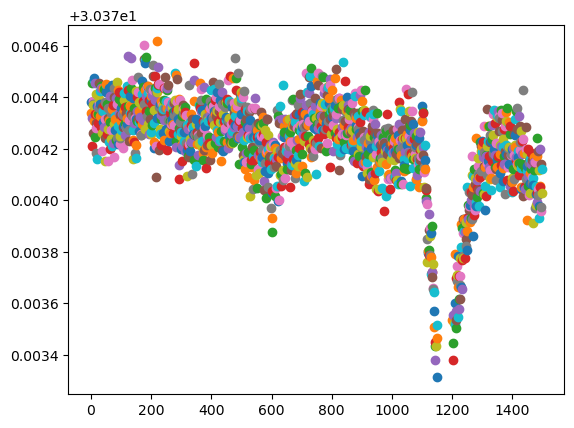

In [30]:
fig,ax=plt.subplots()
for i in range(1500):
    ax.scatter(i,gaussian_fit_eve(wavelength_list_eve,obs[2011011][i]))
ax.scatter(1170,gaussian_fit_eve(wavelength_list_eve,obs[2011011][1170]),marker='x',s=900)

In [32]:
gaussian_fit_eve(wavelength_list_eve,obs[2011011][1170])

nan

In [33]:
irradiance=obs[2011011][1170]
irradiance

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

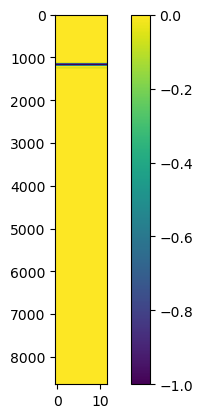

In [34]:

fig,ax=plt.subplots()
sc=ax.imshow(obs[2011011]*(obs[2011011]<0),aspect=0.01)
plt.colorbar(sc)

In [37]:
obs[2011011]

array([[2.65775398e-05, 1.30548782e-04, 5.00766444e-04, ...,
        2.02952448e-04, 7.74215005e-05, 5.15032625e-05],
       [2.40217960e-05, 1.26646890e-04, 4.99048678e-04, ...,
        2.02324998e-04, 7.55215369e-05, 4.94755514e-05],
       [2.69133889e-05, 1.31225854e-04, 5.01633505e-04, ...,
        2.08510086e-04, 8.12409417e-05, 5.37332417e-05],
       ...,
       [2.56111234e-05, 1.21492572e-04, 4.83515032e-04, ...,
        1.99302784e-04, 7.35190115e-05, 5.01047471e-05],
       [2.48915367e-05, 1.24780054e-04, 4.87379555e-04, ...,
        1.94735971e-04, 7.32705594e-05, 4.97229266e-05],
       [2.69294796e-05, 1.26975705e-04, 4.88911697e-04, ...,
        2.01900330e-04, 7.35467402e-05, 4.78482252e-05]])

## plot irradiance

In [51]:
obs_cen_wave

{2011011: array([30.3743811 , 30.37433775, 30.37445438, ..., 30.37451108,
        30.37435202, 30.37442525]),
 2011012: array([30.37429674, 30.37433193, 30.37448087, ..., 30.37422266,
        30.37424663, 30.37436124]),
 2011013: array([30.37424214, 30.37434011, 30.37438492, ..., 30.37448186,
        30.37445229, 30.37438745]),
 2011014: array([30.37439068, 30.37435911, 30.37416811, ..., 30.37423074,
        30.3742138 , 30.37430982]),
 2011015: array([30.37416666, 30.37421266, 30.37425982, ..., 30.37405341,
        30.37435332, 30.37431698]),
 2011016: array([30.37431439, 30.37422119, 30.37429075, ..., 30.37431739,
        30.37437411, 30.37416036]),
 2011017: array([30.37426721, 30.37418408, 30.37422403, ..., 30.37429125,
        30.37430479, 30.3743965 ]),
 2011018: array([30.37422407, 30.37422297, 30.37437429, ..., 30.37444435,
        30.37447344, 30.37437118]),
 2011019: array([30.37421062, 30.37440283, 30.37431443, ..., 30.37443482,
        30.37434249, 30.37446458]),
 2011021: 

In [52]:
list(obs_cen_wave.keys())

[2011011,
 2011012,
 2011013,
 2011014,
 2011015,
 2011016,
 2011017,
 2011018,
 2011019,
 2011021,
 2011022,
 2011023,
 2011024,
 2011025,
 2011026,
 2011027,
 2011028,
 2011029,
 2011031,
 2011032,
 2011033,
 2011034,
 2011035,
 2011036,
 2011037,
 2011038,
 2011039,
 2011041,
 2011042,
 2011043,
 2011044,
 2011045,
 2011046,
 2011047,
 2011048,
 2011049,
 2011051,
 2011052,
 2011053,
 2011054,
 2011055,
 2011056,
 2011057,
 2011058,
 2011059,
 2011061,
 2011062]

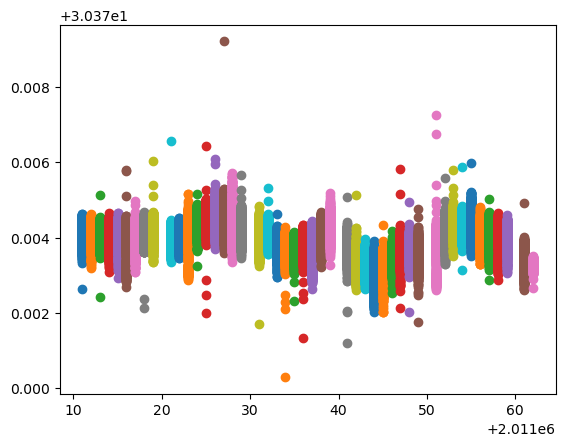

In [53]:
fig,ax=plt.subplots()
for key in list(obs_cen_wave.keys())[:50]:
    key_list=np.tile(key, (8640, 1))
    ax.scatter(key_list,obs_cen_wave[key])

## FFT

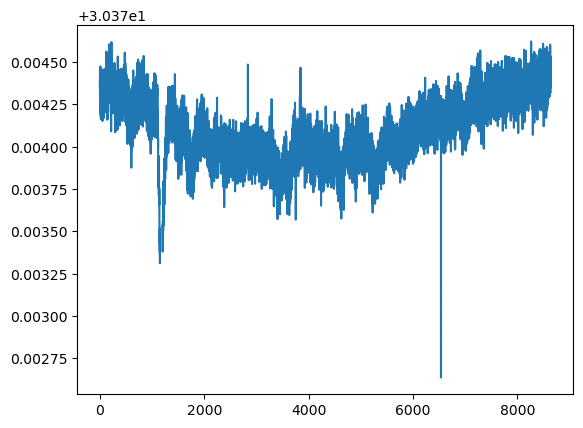

In [55]:
fig,ax=plt.subplots()
ax.plot(obs_cen_wave[2011011])

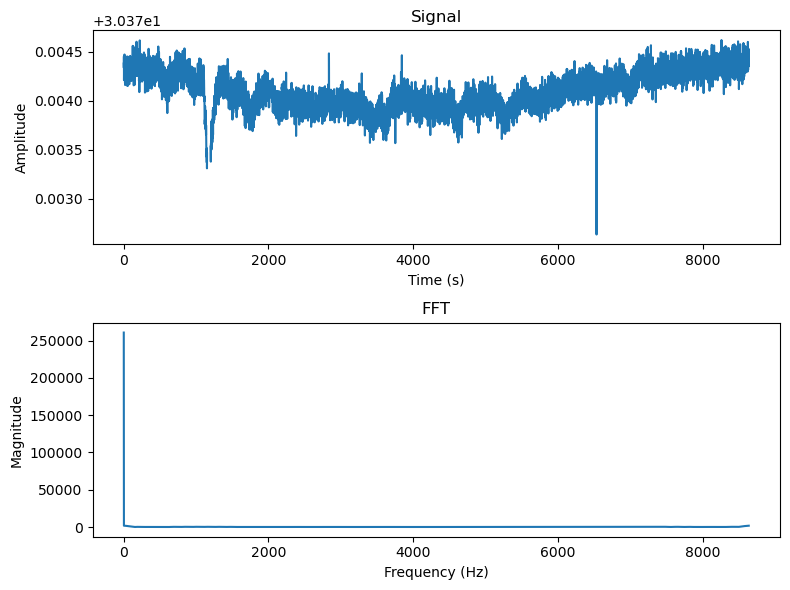

In [51]:
X = np.fft.fft(np.nan_to_num(obs_cen_wave[11]))

# Compute the frequency axis
freqs = np.fft.fftfreq(8640)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot( obs_cen_wave[11])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Signal')

ax[1].plot(np.abs(X))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].set_title('FFT')
# ax[1].set_xlim([-0.001,0.001])

plt.tight_layout()

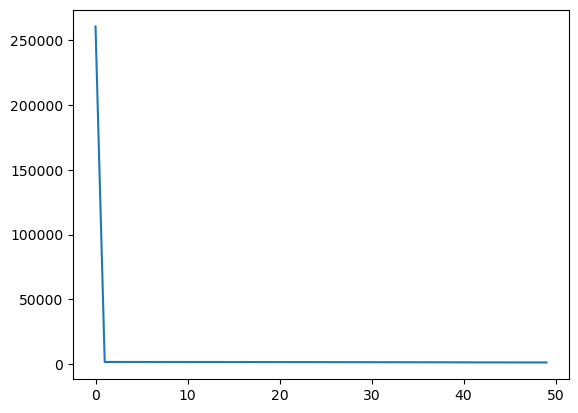

In [56]:
fig, ax = plt.subplots()
ax.plot(np.abs(X)[:50])

In [45]:
np.shape(freqs)

(8640,)

In [48]:
np.shape(X)

(8640,)

In [57]:
X[0]

(260700.92574078086+0j)

In [61]:
X[3]

(1456.2529741675053+932.663183413247j)

In [35]:
8640**-1

0.00011574074074074075

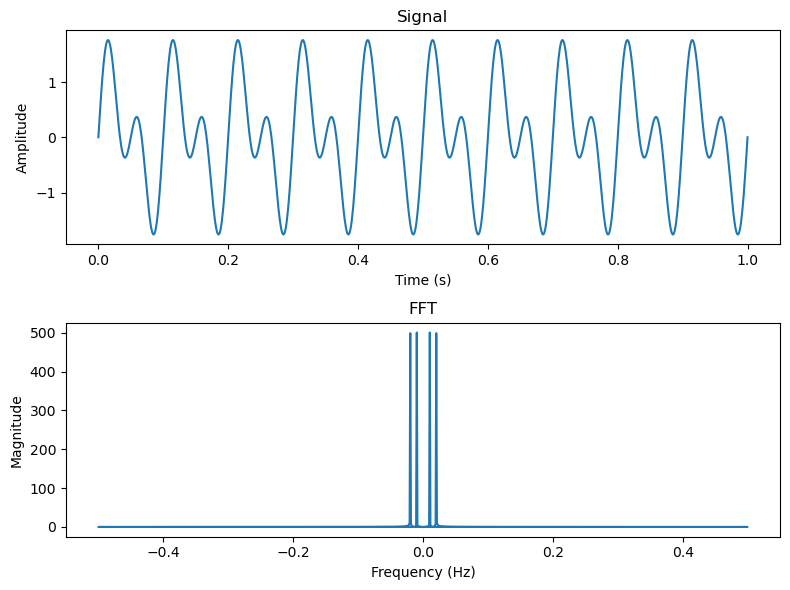

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Generate the signal
N = 1000
t = np.linspace(0, 1, N)
x = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)

# Compute the FFT
X = np.fft.fft(x)

# Compute the frequency axis
freqs = np.fft.fftfreq(N)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(t, x)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Signal')

ax[1].plot(freqs, np.abs(X))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].set_title('FFT')

plt.tight_layout()

In [131]:
X

array([ 1.18064595e+07+3.66929598e-10j,  2.19623592e+01-4.43684272e+01j,
       -3.29456588e+00+4.40165906e+01j, ...,
       -1.33050522e+01-1.81253158e+01j, -3.29456588e+00-4.40165906e+01j,
        2.19623592e+01+4.43684272e+01j])

# Save

## save a dict into npz

In [84]:
obs_cen_wave = {str(k): v for k, v in obs_cen_wave.items()}

In [85]:
obs_cen_wave

{'2011011': array([30.3743811 , 30.37433775, 30.37445438, ..., 30.37451108,
        30.37435202, 30.37442525]),
 '2011012': array([30.37429674, 30.37433193, 30.37448087, ..., 30.37422266,
        30.37424663, 30.37436124]),
 '2011013': array([30.37424214, 30.37434011, 30.37438492, ..., 30.37448186,
        30.37445229, 30.37438745]),
 '2011014': array([30.37439068, 30.37435911, 30.37416811, ..., 30.37423074,
        30.3742138 , 30.37430982]),
 '2011015': array([30.37416666, 30.37421266, 30.37425982, ..., 30.37405341,
        30.37435332, 30.37431698]),
 '2011016': array([30.37431439, 30.37422119, 30.37429075, ..., 30.37431739,
        30.37437411, 30.37416036]),
 '2011017': array([30.37426721, 30.37418408, 30.37422403, ..., 30.37429125,
        30.37430479, 30.3743965 ]),
 '2011018': array([30.37422407, 30.37422297, 30.37437429, ..., 30.37444435,
        30.37447344, 30.37437118]),
 '2011019': array([30.37421062, 30.37440283, 30.37431443, ..., 30.37443482,
        30.37434249, 30.3744

In [86]:
np.savez("eve_part/data/central_wavelength.npz", **obs_cen_wave)

## save median

In [64]:
np.shape(obs_cen_wave['2011011'])

(8640,)

In [87]:
np.nanmedian(obs_cen_wave['2011011'])

30.37408671287927

In [95]:
a=[1,2]
np.append(a,3)

array([1, 2, 3])

In [104]:
daily_mean=[]
daily_stddev=[]
for key in obs_cen_wave.keys():
    daily_mean.append(
        np.nanmedian(obs_cen_wave[key]))
    daily_stddev.append(
        np.nanstd(obs_cen_wave[key]))

In [97]:
daily_mean

[30.37408671287927,
 30.374089867179094,
 30.374054606530134,
 30.374055134384538,
 30.374070524038963,
 30.374059313309488,
 30.37406324701104,
 30.37412304029711,
 30.37414980423501,
 30.37390784841134,
 30.373962951979934,
 30.37412439110773,
 30.374345632832053,
 30.374522396096253,
 30.374495036308694,
 30.37439274773219,
 30.374360881789748,
 30.374334925159708,
 30.374222495737847,
 30.374082128896298,
 30.37383779903757,
 30.373759899115164,
 30.373643456712433,
 30.373742897719637,
 30.373949754743737,
 30.374070691243276,
 30.37424083791474,
 30.373785044007068,
 30.373490394203603,
 30.373372508074716,
 30.373324847086344,
 30.3733369697493,
 30.37339631822673,
 30.373631672355433,
 30.373694588374747,
 30.373577076422613,
 30.373923353732774,
 30.37414962266334,
 30.37433321230297,
 30.37432454453255,
 30.374297495019338,
 30.37420225121867,
 30.37421374116224,
 30.374197773634144,
 30.37403318435567,
 30.37346164352515,
 30.373260115100294]

### dataframe indexed by date

In [116]:
list(obs_cen_wave.keys())

['2011011',
 '2011012',
 '2011013',
 '2011014',
 '2011015',
 '2011016',
 '2011017',
 '2011018',
 '2011019',
 '2011021',
 '2011022',
 '2011023',
 '2011024',
 '2011025',
 '2011026',
 '2011027',
 '2011028',
 '2011029',
 '2011031',
 '2011032',
 '2011033',
 '2011034',
 '2011035',
 '2011036',
 '2011037',
 '2011038',
 '2011039',
 '2011041',
 '2011042',
 '2011043',
 '2011044',
 '2011045',
 '2011046',
 '2011047',
 '2011048',
 '2011049',
 '2011051',
 '2011052',
 '2011053',
 '2011054',
 '2011055',
 '2011056',
 '2011057',
 '2011058',
 '2011059',
 '2011061',
 '2011062']

In [160]:
# Define the yyyydoy string
yyyydoy = '2023125'

# Parse the yyyydoy string and convert it to a datetime object
date = datetime.strptime(yyyydoy, '%Y%j')
date


datetime.datetime(2023, 5, 5, 0, 0)

In [162]:
#将yyyydoy string 转换为 datetime
date=[]
for key in obs_cen_wave.keys():
    date.append(datetime.strptime(key, '%Y%j'))

In [163]:
# 先写出dict
daily_data={"date":date,
            "daily_mean":daily_mean,
            "daily_stddev":daily_stddev,
           }

In [164]:
frame=pd.DataFrame(daily_data)
frame = frame.set_index('date')
frame.head()

daily_mean  daily_stddev
date                                
2011-01-11   30.374087      0.000191
2011-01-12   30.374090      0.000170
2011-01-13   30.374055      0.000182
2011-01-14   30.374055      0.000181
2011-01-15   30.374071      0.000179

In [135]:
frame.index

Index(['2011011', '2011012', '2011013', '2011014', '2011015', '2011016',
       '2011017', '2011018', '2011019', '2011021', '2011022', '2011023',
       '2011024', '2011025', '2011026', '2011027', '2011028', '2011029',
       '2011031', '2011032', '2011033', '2011034', '2011035', '2011036',
       '2011037', '2011038', '2011039', '2011041', '2011042', '2011043',
       '2011044', '2011045', '2011046', '2011047', '2011048', '2011049',
       '2011051', '2011052', '2011053', '2011054', '2011055', '2011056',
       '2011057', '2011058', '2011059', '2011061', '2011062'],
      dtype='object', name='date')

In [134]:
frame.loc['2011011']

daily_mean      30.374087
daily_stddev     0.000191
Name: 2011011, dtype: float64

In [133]:
frame.loc['2011011']['daily_stddev']

0.00019111376535535814

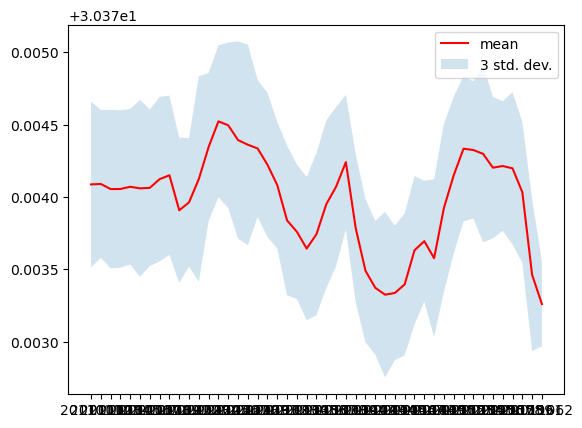

In [148]:
fig,ax=plt.subplots()
ax.plot(frame.index,frame['daily_mean'],'r-',label='mean')

ax.fill_between(frame.index,
                frame['daily_mean']-3*frame['daily_stddev'],
                frame['daily_mean']+3*frame['daily_stddev'],
               alpha=0.2,
               label='3 std. dev.')

ax.legend()

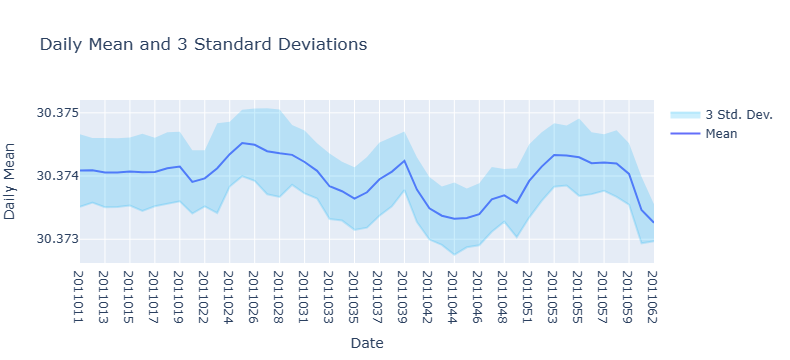

In [157]:
fig = go.Figure()

# Plot the mean line
fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'], mode='lines', name='Mean'))

# Plot the shaded area between the mean and 3 standard deviations
fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'] + 3*frame['daily_stddev'], 
                         mode='lines', line=dict(color='rgba(0,0,0,0)'), showlegend=False))

fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'] - 3*frame['daily_stddev'], 
                         mode='lines', fill='tonexty', fillcolor='rgba(0,176,246,0.2)', 
                         line=dict(color='rgba(0,176,246,0.2)'), name='3 Std. Dev.'))

# Add axis labels and titles
fig.update_layout(xaxis_title='Date', yaxis_title='Daily Mean', 
                  title='Daily Mean and 3 Standard Deviations')


In [45]:
mean={str(k): v for k, v in mean.items()}
np.savez("eve_part/daily_median.npz", **mean)

In [44]:
mean.keys()

dict_keys(['2011-01-11 00:00:00', '2011-01-12 00:00:00', '2011-01-13 00:00:00', '2011-01-14 00:00:00', '2011-01-15 00:00:00', '2011-01-16 00:00:00', '2011-01-17 00:00:00', '2011-01-18 00:00:00', '2011-01-19 00:00:00', '2011-01-21 00:00:00', '2011-01-22 00:00:00', '2011-01-23 00:00:00', '2011-01-24 00:00:00', '2011-01-25 00:00:00', '2011-01-26 00:00:00', '2011-01-27 00:00:00', '2011-01-28 00:00:00', '2011-01-29 00:00:00', '2011-01-31 00:00:00', '2011-02-01 00:00:00', '2011-02-02 00:00:00', '2011-02-03 00:00:00', '2011-02-04 00:00:00', '2011-02-05 00:00:00', '2011-02-06 00:00:00', '2011-02-07 00:00:00', '2011-02-08 00:00:00', '2011-02-10 00:00:00', '2011-02-11 00:00:00', '2011-02-12 00:00:00', '2011-02-13 00:00:00', '2011-02-14 00:00:00', '2011-02-15 00:00:00', '2011-02-16 00:00:00', '2011-02-17 00:00:00', '2011-02-18 00:00:00', '2011-02-20 00:00:00', '2011-02-21 00:00:00', '2011-02-22 00:00:00', '2011-02-23 00:00:00', '2011-02-24 00:00:00', '2011-02-25 00:00:00', '2011-02-26 00:00:00', 

# Read & Processing

### read daily 

In [2]:
loaded_dict = np.load("eve_part/central_wavelength.npz")
format_string = '%Y-%m-%d %H:%M:%S'
loaded_dict={datetime.strptime(k, format_string ):loaded_dict[k] for k in loaded_dict.keys()}

In [20]:
loaded_dict?
loaded_dict.files

Type:        dict
String form:
{datetime.datetime(2011, 1, 11, 0, 0): array([30.3743811 , 30.37433775, 30.37445438, ..., 30.3745 <...> rray([30.37292744, 30.3727826 , 30.37302595, ...,         nan,
           nan,         nan])}
Length:      283
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

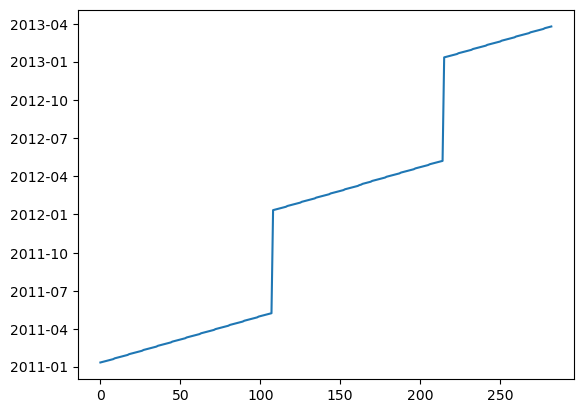

In [21]:
fig,ax=plt.subplots()
ax.plot(list(loaded_dict.keys()))

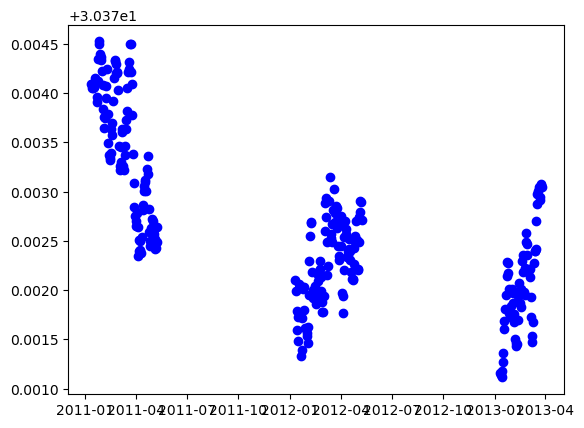

In [9]:
fig,ax=plt.subplots()
for key in list(loaded_dict.keys()):
    ax.scatter(key,np.nanmedian(loaded_dict[key]),c='b')

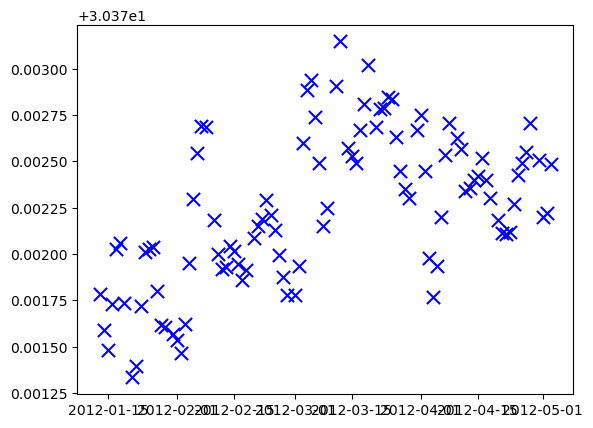

In [10]:
fig,ax=plt.subplots()
for key in list(loaded_dict.keys())[110:210]:
    # key_list=np.tile(key, (8640, 1))
    # ax.scatter(key_list,loaded_dict[key])
    ax.scatter(key,np.nanmedian(loaded_dict[key]),c='b',marker='x',s=90)

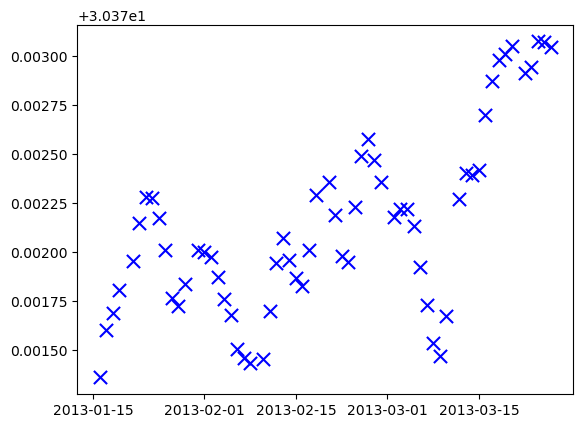

In [11]:
fig,ax=plt.subplots()
for key in list(loaded_dict.keys())[220:]:
    # key_list=np.tile(key, (8640, 1))
    # ax.scatter(key_list,loaded_dict[key])
    ax.scatter(key,np.nanmedian(loaded_dict[key]),c='b',marker='x',s=90)

#### don't run this plotly

Text(0.5, 0, 'date')

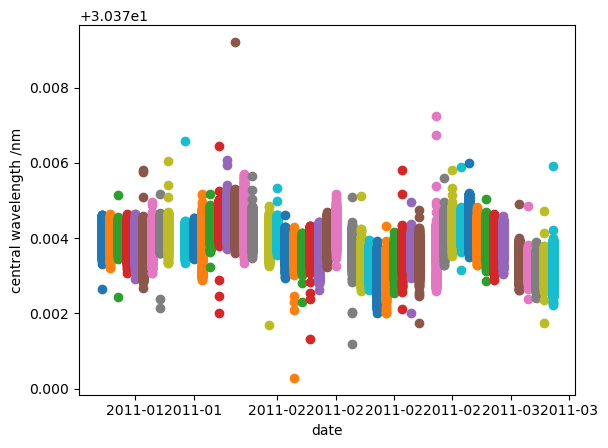

In [14]:
fig,ax=plt.subplots()
for key in list(loaded_dict.keys())[:50]:
    key_list = np.tile(key, (8640,))
    # Add a scatter trace for the current key
    ax.scatter(key_list,loaded_dict[key])
    
    
date_fmt = '%Y-%m'
date_formatter = plt.matplotlib.dates.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)

ax.set_ylabel('central wavelength /nm')
ax.set_xlabel('date')

In [ ]:
# Create an empty figure

fig = go.Figure()

# Loop over the first 50 keys in loaded_dict
for key in list(loaded_dict.keys())[:50]:
    key_list = np.tile(key, (8640,))
    # Add a scatter trace for the current key
    fig.add_trace(go.Scatter(x=key_list, y=loaded_dict[key], mode='markers'))



# Show the figure
fig.show()

In [16]:
# Combine all the data into a single array
all_values = np.concatenate(list(loaded_dict.values())[:30])

# Create an array of keys corresponding to the values
keys = []
for key in list(loaded_dict.keys())[:30]:
    keys += [key] * len(loaded_dict[key])

# Create a scatter trace for all the data
trace = go.Scatter(x=keys, y=all_values, mode='markers')

# Create a figure and add the trace
fig = go.Figure(data=trace)

# Set the x-axis and y-axis titles
fig.update_layout(xaxis_title='Key', yaxis_title='Value')

# Save the figure as an HTML file
fig.write_html('scatter_plot.html')

#### Concolution

In [18]:
loaded_dict.values()

dict_values([array(30.37408671), array(30.37408987), array(30.37405461), array(30.37405513), array(30.37407052), array(30.37405931), array(30.37406325), array(30.37410833), array(30.3741498), array(30.37390785), array(30.37396295), array(30.37412439), array(30.37434563), array(30.3745224), array(30.37449504), array(30.37439275), array(30.37436088), array(30.37433493), array(30.3742225), array(30.37408213), array(30.3738378), array(30.3737599), array(30.37364346), array(30.3737429), array(30.37394975), array(30.37407069), array(30.37424084), array(30.37378504), array(30.37349039), array(30.37337251), array(30.37332485), array(30.37333697), array(30.37339632), array(30.37363167), array(30.37369459), array(30.37357708), array(30.37392335), array(30.37414962), array(30.37433321), array(30.37432454), array(30.3742975), array(30.37420225), array(30.37421374), array(30.37419777), array(30.37403318), array(30.37346164), array(30.37326399), array(30.37322297), array(30.37329794), array(30.37345

In [30]:
np.shape(combined_array)[0]

8583

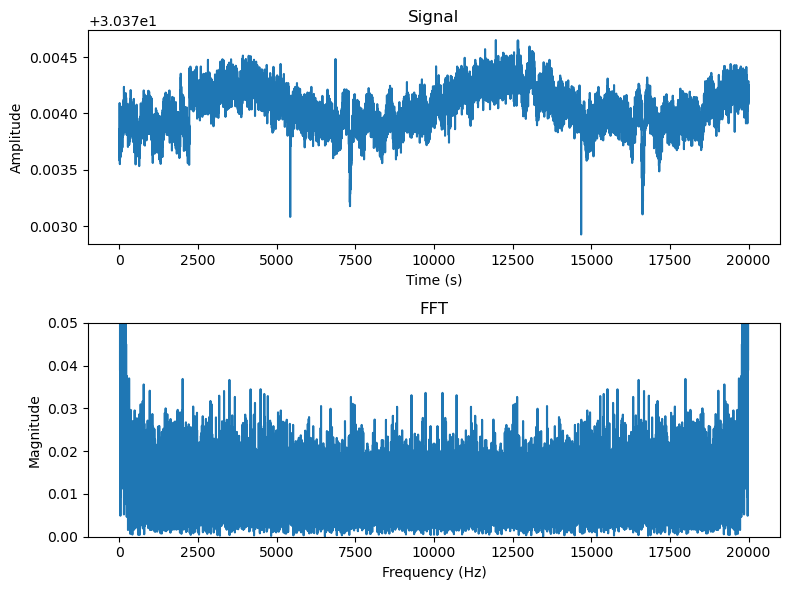

In [155]:
num=20000
a=np.nan_to_num(combined_array[num:2*num])

X = np.fft.fft(a)

# Compute the frequency axis
# freqs = np.fft.fftfreq(np.shape(combined_array)[0])


freqs = np.fft.fftfreq(num)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(a)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Signal')

ax[1].plot(np.abs(X))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].set_title('FFT')
ax[1].set_ylim((0,0.05))
# ax[1].set_xlim([-0.001,0.001])

plt.tight_layout()

In [145]:
combined_array = np.concatenate(list(loaded_dict.values()))
# get the indices of the NaN values
nan_indices = np.isnan(combined_array)

# delete the NaN values using the indices
combined_array = np.delete(combined_array, np.where(nan_indices))

(239001,)


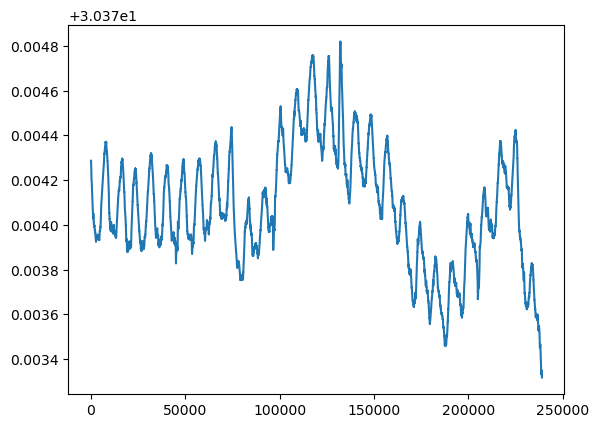

In [153]:
N=1000
# Define smoothing kernel
smoothing_kernel = np.ones(N) / N

# Apply convolution
# smoothed_array = np.convolve(np.nan_to_num(combined_array), smoothing_kernel, mode='valid')

smoothed_array = signal.convolve(cp.array(np.nan_to_num(combined_array)[:30*8000]), cp.array(smoothing_kernel)
                                 , mode='valid')

print(np.shape(smoothed_array))

fig,ax=plt.subplots()
ax.plot(smoothed_array.get())
# ax.plot(    np.nan_to_num(combined_array) )

In [113]:
# Define input array
input_array = np.array([1, 2, 3, 4, 50, 
                        60, 700, 800, 9000, 10000])

# Define smoothing kernel
smoothing_kernel = np.ones(3) / 3

# Apply convolution
smoothed_array = np.convolve(input_array, smoothing_kernel, mode='same')

print(smoothed_array)


[1.00000000e+00 2.00000000e+00 3.00000000e+00 1.90000000e+01
 3.80000000e+01 2.70000000e+02 5.20000000e+02 3.50000000e+03
 6.60000000e+03 6.33333333e+03]


In [129]:
def doppler_to_wavelength(std_wavelength, doppler_velocity):
    beta = doppler_velocity / const.c
    return (std_wavelength *beta).to(u.nm)

### read daily median

In [159]:
loaded_dict = np.load("eve_part/daily_median.npz")
format_string = '%Y-%m-%d %H:%M:%S'
loaded_dict={datetime.strptime(k, format_string):loaded_dict[k] for k in loaded_dict.keys()}

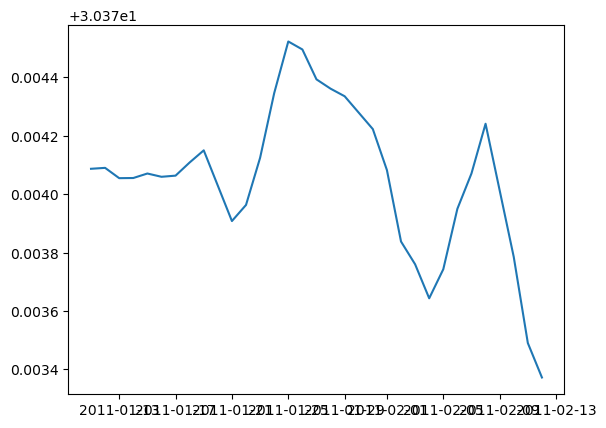

In [160]:
fig,ax=plt.subplots()
num=30
ax.plot(list(loaded_dict.keys())[:num],list(loaded_dict.values())[:num])

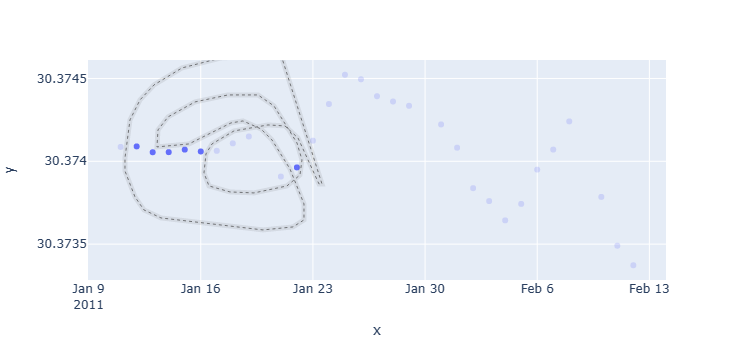

In [161]:
fig = px.scatter(x=list(loaded_dict.keys())[:num],y=list(loaded_dict.values())[:num])
fig.show()

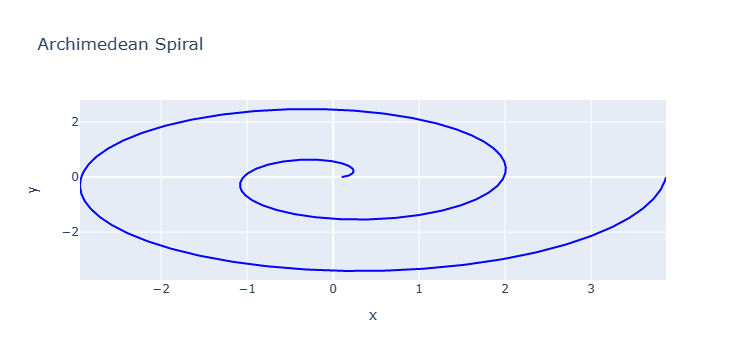

In [1]:
import numpy as np
import plotly.graph_objects as go

# Define the parameters of the Archimedean spiral
a = 0.1  # distance between successive turns
b = 0.3  # offset of the starting point from the origin

# Create an array of angles from 0 to 4pi
theta = np.linspace(0, 4 * np.pi, 1000)

# Calculate the corresponding x and y coordinates
x = (a + b * theta) * np.cos(theta)
y = (a + b * theta) * np.sin(theta)

# Create a Plotly scatter plot of the Archimedean spiral
fig = go.Figure(
    go.Scatter(
        x=x,
        y=y,
        mode="lines",
        line=dict(width=2, color="blue"),
    )
)

# Set the axis labels and title
fig.update_layout(
    title="Archimedean Spiral",
    xaxis_title="x",
    yaxis_title="y",
)

# Show the plot
fig.show()